In [15]:
import os
import re
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

from dotenv import load_dotenv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity as sk_cosine_similarity
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sentence_transformers import SentenceTransformer
from groq import Groq
from sklearn.utils.class_weight import compute_class_weight
from sklearn.base import BaseEstimator, TransformerMixin
from transformers import AutoTokenizer, AutoModel

# Load environment variables
load_dotenv()

# Download NLTK stopwords (if not already done)
# nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

In [16]:
# Preprocessing Helper Function
def preprocess_text(text):
    text = str(text).lower().strip()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in text.split() if word not in stop_words]
    return " ".join(tokens)

In [17]:
# Traditional Similarity Methods Class
class TraditionalSimilarity:
    def __init__(self):
        self.tfidf_vectorizer = TfidfVectorizer(min_df=1, stop_words=None, lowercase=False, token_pattern=r'\S+')
    
    def jaccard_similarity(self, q1, q2):
        words1 = set(q1.split())
        words2 = set(q2.split())
        intersection = len(words1.intersection(words2))
        union = len(words1.union(words2))
        return intersection / union if union != 0 else 0

    def levenshtein_similarity(self, s1, s2):
        m, n = len(s1), len(s2)
        dp = np.zeros((m+1, n+1), dtype=int)
        for i in range(m+1):
            dp[i][0] = i
        for j in range(n+1):
            dp[0][j] = j
        for i in range(1, m+1):
            for j in range(1, n+1):
                if s1[i-1] == s2[j-1]:
                    dp[i][j] = dp[i-1][j-1]
                else:
                    dp[i][j] = 1 + min(dp[i-1][j], dp[i][j-1], dp[i-1][j-1])
        max_len = max(m, n)
        return 1 - (dp[m][n] / max_len) if max_len != 0 else 0

    def tfidf_cosine_similarity(self, q1, q2):
        tfidf_matrix = self.tfidf_vectorizer.fit_transform([q1, q2])
        return sk_cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])[0][0]

In [18]:
class AIEnhancedSimilarity:
    def __init__(self, model_names=['sentence-transformers/all-mpnet-base-v2']):
        self.models = [SentenceTransformer(name) for name in model_names]
    
    def semantic_similarity(self, q1, q2):
        embeddings = [model.encode([q1, q2]) for model in self.models]
        similarities = [
            np.dot(emb[0], emb[1]) / (np.linalg.norm(emb[0]) * np.linalg.norm(emb[1]))
            for emb in embeddings
        ]
        return np.mean(similarities)

In [19]:

# LLM-based Similarity via Groq API
class LLMBasedSimilarity:
    def __init__(self):
        self.client = Groq(api_key=os.getenv("GROQ_API_KEY1"))
    
    def predict_duplicate(self, q1, q2):
        prompt = f"Question 1: {q1}\nQuestion 2: {q2}\nAre these questions duplicates? Answer with Yes or No:"
        
        chat_completion = self.client.chat.completions.create(
            messages=[
                {"role": "user", "content": prompt}
            ],
            model="deepseek-r1-distill-llama-70b",
            max_tokens=10,
            temperature=0
        )
        
        generated_text = chat_completion.choices[0].message.content
        return 1 if "yes" in generated_text.lower() else 0

In [20]:
# Custom Transformer for feature extraction
class SimilarityFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.trad_sim = TraditionalSimilarity()
        self.ai_sim = AIEnhancedSimilarity()
        self.llm_sim = LLMBasedSimilarity()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        features = []
        for _, row in X.iterrows():
            q1, q2 = row['question1'], row['question2']
            features.append([
                self.trad_sim.jaccard_similarity(q1, q2),
                self.trad_sim.levenshtein_similarity(q1, q2),
                self.trad_sim.tfidf_cosine_similarity(q1, q2),
                self.ai_sim.semantic_similarity(q1, q2),
                self.llm_sim.predict_duplicate(q1, q2)
            ])
        return np.array(features)

In [21]:

# Data Loading and Preprocessing
sample_size = 100  # Increased sample size
df = pd.read_csv('train.csv', nrows=sample_size)
df['question1'] = df['question1'].apply(preprocess_text)
df['question2'] = df['question2'].apply(preprocess_text)

# Feature Extraction
print("Extracting features...")
feature_extractor = SimilarityFeatureExtractor()
X = feature_extractor.transform(df)
y = df['is_duplicate'].values

# Calculate individual similarity accuracies
print("Calculating individual similarity accuracies...")

jaccard_pred = X[:, 0] > 0.5
levenshtein_pred = X[:, 1] > 0.5
tfidf_pred = X[:, 2] > 0.5
semantic_pred = X[:, 3] > 0.5
llm_pred = X[:, 4] > 0.5

jaccard_acc = accuracy_score(y, jaccard_pred)
levenshtein_acc = accuracy_score(y, levenshtein_pred)
tfidf_acc = accuracy_score(y, tfidf_pred)
semantic_acc = accuracy_score(y, semantic_pred)
llm_acc = accuracy_score(y, llm_pred)

print("\nAccuracies for each similarity method:")
print(f"Jaccard Similarity: {jaccard_acc:.4f}")
print(f"Levenshtein Similarity: {levenshtein_acc:.4f}")
print(f"TF-IDF Cosine Similarity: {tfidf_acc:.4f}")
print(f"Semantic Similarity: {semantic_acc:.4f}")
print(f"LLM-based Similarity: {llm_acc:.4f}")

Extracting features...
Calculating individual similarity accuracies...

Accuracies for each similarity method:
Jaccard Similarity: 0.6200
Levenshtein Similarity: 0.7000
TF-IDF Cosine Similarity: 0.6100
Semantic Similarity: 0.5800
LLM-based Similarity: 0.6500


In [22]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle Class Imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
clf = RandomForestClassifier(n_estimators=1000, random_state=42, class_weight=dict(enumerate(class_weights)))

# Cross-validation
cv_scores = cross_val_score(clf, X_train_scaled, y_train, cv=5)
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f}")

# Train the model
clf.fit(X_train_scaled, y_train)

# Predictions and Evaluation
y_pred = clf.predict(X_test_scaled)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Combined model accuracy
combined_acc = accuracy_score(y_test, y_pred)
print(f"\nCombined Model Accuracy: {combined_acc:.4f}")

# Feature Importance
feature_names = ['Jaccard', 'Levenshtein', 'TF-IDF Cosine', 'Semantic', 'LLM']
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)


Cross-validation scores: [0.6875 0.8125 0.8125 0.6875 0.9375]
Mean CV score: 0.7875

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80        15
           1       0.50      1.00      0.67         5

    accuracy                           0.75        20
   macro avg       0.75      0.83      0.73        20
weighted avg       0.88      0.75      0.77        20


Confusion Matrix:
[[10  5]
 [ 0  5]]

Combined Model Accuracy: 0.7500

Feature Importance:
         feature  importance
3       Semantic    0.384426
1    Levenshtein    0.240580
0        Jaccard    0.201824
2  TF-IDF Cosine    0.173170
4            LLM    0.000000


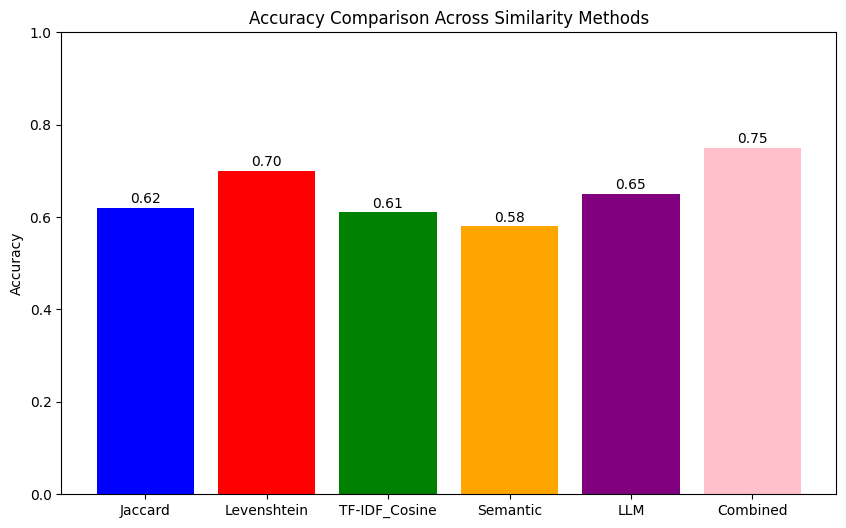

In [23]:
# Plot a bar graph comparing these accuracies
methods = ["Jaccard", "Levenshtein", "TF-IDF_Cosine","Semantic", "LLM", "Combined"]
accuracies = [jaccard_acc, levenshtein_acc, tfidf_acc, semantic_acc, llm_acc, combined_acc]
plt.figure(figsize=(10, 6))
plt.bar(methods, accuracies, color=["blue", "red","green", "orange", "purple", "pink"])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison Across Similarity Methods")
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha="center")
plt.show()

In [24]:
# Sample Prediction Function
def predict_similarity(q1, q2, threshold=0.5):
    q1_processed = preprocess_text(q1)
    q2_processed = preprocess_text(q2)
    feat = feature_extractor.transform(pd.DataFrame({'question1': [q1_processed], 'question2': [q2_processed]}))
    feat_scaled = scaler.transform(feat)
    proba = clf.predict_proba(feat_scaled)[0][1]
    pred = 1 if proba >= threshold else 0
    return pred, proba

# Example usage
q1_sample = "he is vinay"
q2_sample = "his name is vinay"
prediction, probability = predict_similarity(q1_sample, q2_sample)
print(f"\nSample Prediction:")
print(f"Question 1: {q1_sample}")
print(f"Question 2: {q2_sample}")
print(f"Predicted as duplicate (1 = yes): {prediction} with probability {probability:.2f}")


Sample Prediction:
Question 1: he is vinay
Question 2: his name is vinay
Predicted as duplicate (1 = yes): 1 with probability 0.78


In [ ]:
from flask import Flask, request, render_template_string
import threading

# Flask App Setup
app = Flask(__name__)

# Sample Prediction Function
def predict_similarity(q1, q2, threshold=0.5):
    q1_processed = preprocess_text(q1)
    q2_processed = preprocess_text(q2)
    feat = feature_extractor.transform(pd.DataFrame({'question1': [q1_processed], 'question2': [q2_processed]}))
    feat_scaled = scaler.transform(feat)
    proba = clf.predict_proba(feat_scaled)[0][1]
    pred = 1 if proba >= threshold else 0
    return pred, proba
@app.route("/", methods=["GET", "POST"])
def index():
    result = ""
    if request.method == "POST":
        user_q1 = request.form.get("question1")
        user_q2 = request.form.get("question2")
        
        # Call your pre-defined predict_similarity() function from the previous snippet
        pred, proba = predict_similarity(user_q1, user_q2)
        
        # Create a result message based on the prediction
        result = "✅ Matched (Duplicate)" if pred == 1 else "❌ Not Matched"
        result += f" with probability {proba:.2f}"
    
    # HTML Template for the form and display of result
    html = """
    <!doctype html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1">
        <title>Quora Question Pair Similarity Using DeepSeek API</title>
        <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.0/dist/css/bootstrap.min.css">
        <style>
            body { background-color: #f8f9fa; }
            .container {
                max-width: 600px;
                background: white;
                padding: 25px;
                margin-top: 50px;
                border-radius: 10px;
                box-shadow: 0 0 20px rgba(0,0,0,0.1);
            }
            .result { margin-top: 20px; font-size: 18px; }
        </style>
    </head>
    <body>
        <div class="container">
            <h2 class="text-center">Quora Question Pair Similarity Evaluation using DeepSeek API</h2>
            <form method="post">
                <div class="mb-3">
                    <label for="question1" class="form-label">Question 1:</label>
                    <input type="text" id="question1" name="question1" class="form-control" required>
                </div>
                <div class="mb-3">
                    <label for="question2" class="form-label">Question 2:</label>
                    <input type="text" id="question2" name="question2" class="form-control" required>
                </div>
                <button type="submit" class="btn btn-primary w-100">Check Similarity</button>
                <button type="reset" class="btn btn-secondary w-100 mt-2" onclick="resetForm()">Reset</button>
            </form>
            
            {% if result %}
                <div class="result alert alert-info text-center mt-3">
                    Result: {{ result }}
                </div>
            {% endif %}
        </div>
        <script>
            function resetForm() {
                document.getElementById("question1").value = '';
                document.getElementById("question2").value = '';
                let resultDiv = document.querySelector('.result');
                if(resultDiv) { resultDiv.style.display = 'none'; }
            }
        </script>
    </body>
    </html>
    """
    return render_template_string(html, result=result)

# Function to run Flask app in a separate thread
def run_flask():
    app.run(host="127.0.0.102", port=5000, debug=False, use_reloader=False)

# Start the Flask app in a separate thread
thread = threading.Thread(target=run_flask)
thread.start()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.102:5000
Press CTRL+C to quit
